<a href="https://colab.research.google.com/github/wlg100/numseqcont_circuit_expms/blob/main/notebook_templates/minimal_circuit_template.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" align="left"/></a>&nbsp;or in a local notebook.

# Setup
(No need to change anything)

In [ ]:
# Janky code to do different setup when run in a Colab notebook vs VSCode
DEBUG_MODE = False
try:
    import google.colab
    IN_COLAB = True
    print("Running as a Colab notebook")
    %pip install git+https://github.com/neelnanda-io/TransformerLens.git
    # Install another version of node that makes PySvelte work way faster
    !curl -fsSL https://deb.nodesource.com/setup_16.x | sudo -E bash -; sudo apt-get install -y nodejs
    %pip install git+https://github.com/neelnanda-io/PySvelte.git
except:
    IN_COLAB = False
    print("Running as a Jupyter notebook - intended for development only!")
    from IPython import get_ipython

    ipython = get_ipython()
    # Code to automatically update the HookedTransformer code as its edited without restarting the kernel
    ipython.magic("load_ext autoreload")
    ipython.magic("autoreload 2")

Running as a Colab notebook
  Cloning https://github.com/neelnanda-io/TransformerLens.git to /tmp/pip-req-build-fho3vksd
  Running command git clone --filter=blob:none --quiet https://github.com/neelnanda-io/TransformerLens.git /tmp/pip-req-build-fho3vksd
  Resolved https://github.com/neelnanda-io/TransformerLens.git to commit e9bbd6a95058ab0b5d6ba44223ee05564384f2ce
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.7/739.7 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 49.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 99.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 91.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━

In [ ]:
# Plotly needs a different renderer for VSCode/Notebooks vs Colab argh
import plotly.io as pio

if IN_COLAB or not DEBUG_MODE:
    # Thanks to annoying rendering issues, Plotly graphics will either show up in colab OR Vscode depending on the renderer - this is bad for developing demos! Thus creating a debug mode.
    pio.renderers.default = "colab"
else:
    pio.renderers.default = "png"

In [ ]:
# Import stuff
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import einops
from fancy_einsum import einsum
import tqdm.notebook as tqdm
import random
from pathlib import Path
import plotly.express as px
from torch.utils.data import DataLoader

from jaxtyping import Float, Int
from typing import List, Union, Optional
from functools import partial
import copy

import itertools
from transformers import AutoModelForCausalLM, AutoConfig, AutoTokenizer
import dataclasses
import datasets
from IPython.display import HTML

In [ ]:
import pysvelte

import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)  # Hooking utilities
from transformer_lens import HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache

We turn automatic differentiation off, to save GPU memory, as this notebook focuses on model inference not model training.

In [ ]:
torch.set_grad_enabled(False)

Plotting helper functions:

In [ ]:
def imshow(tensor, renderer=None, **kwargs):
    px.imshow(utils.to_numpy(tensor), color_continuous_midpoint=0.0, color_continuous_scale="RdBu", **kwargs).show(renderer)

def line(tensor, renderer=None, **kwargs):
    px.line(y=utils.to_numpy(tensor), **kwargs).show(renderer)

def scatter(x, y, xaxis="", yaxis="", caxis="", renderer=None, **kwargs):
    x = utils.to_numpy(x)
    y = utils.to_numpy(y)
    px.scatter(y=y, x=x, labels={"x":xaxis, "y":yaxis, "color":caxis}, **kwargs).show(renderer)

# Load Model

Decide which model to use (eg. gpt2-small vs -medium)

In [ ]:
model = HookedTransformer.from_pretrained(
    "gpt2-small",
    center_unembed=True,
    center_writing_weights=True,
    fold_ln=True,
    refactor_factored_attn_matrices=True,
)

Using pad_token, but it is not set yet.


Loaded pretrained model gpt2-small into HookedTransformer


# Import functions from repo

In [ ]:
!git clone https://github.com/callummcdougall/ARENA_2.0.git

Cloning into 'ARENA_2.0'...
remote: Enumerating objects: 9006, done.
remote: Counting objects: 100% (9006/9006), done.
remote: Compressing objects: 100% (3497/3497), done.
remote: Total 9006 (delta 5468), reused 8860 (delta 5412), pack-reused 0
Receiving objects: 100% (9006/9006), 155.22 MiB | 36.71 MiB/s, done.
Resolving deltas: 100% (5468/5468), done.


In [ ]:
cd ARENA_2.0/chapter1_transformers/exercises/part3_indirect_object_identification

/content/ARENA_2.0/chapter1_transformers/exercises/part3_indirect_object_identification


In [ ]:
import ioi_circuit_extraction as ioi_circuit_extraction

# Generate dataset with multiple prompts

In [ ]:
class Dataset:
    def __init__(self, prompts, tokenizer, S1_is_first=False):
        self.prompts = prompts
        self.tokenizer = tokenizer
        self.N = len(prompts)
        self.max_len = max(
            [
                len(self.tokenizer(prompt["text"]).input_ids)
                for prompt in self.prompts
            ]
        )
        # all_ids = [prompt["TEMPLATE_IDX"] for prompt in self.ioi_prompts]
        all_ids = [0 for prompt in self.prompts] # only 1 template
        all_ids_ar = np.array(all_ids)
        self.groups = []
        for id in list(set(all_ids)):
            self.groups.append(np.where(all_ids_ar == id)[0])

        texts = [ prompt["text"] for prompt in self.prompts ]
        self.toks = torch.Tensor(self.tokenizer(texts, padding=True).input_ids).type(
            torch.int
        )
        self.io_tokenIDs = [
            self.tokenizer.encode(" " + prompt["S5"])[0] for prompt in self.prompts
        ]
        self.s_tokenIDs = [
            self.tokenizer.encode(" " + prompt["S4"])[0] for prompt in self.prompts
        ]

        # word_idx: for every prompt, find the token index of each target token and "end"
        # word_idx is a tensor with an element for each prompt. The element is the targ token's ind at that prompt
        self.word_idx = {}
        for targ in [key for key in self.prompts[0].keys() if (key != 'text' and key != 'S5')]:
            targ_lst = []
            for prompt in self.prompts:
                input_text = prompt["text"]
                tokens = model.tokenizer.tokenize(input_text)
                if S1_is_first and targ == "S1":  # only use this if first token doesn't have space Ġ in front
                    target_token = prompt[targ]
                else:
                    target_token = "Ġ" + prompt[targ]
                target_index = tokens.index(target_token)
                targ_lst.append(target_index)
            self.word_idx[targ] = torch.tensor(targ_lst)

        targ_lst = []
        for prompt in self.prompts:
            input_text = prompt["text"]
            tokens = self.tokenizer.tokenize(input_text)
            end_token_index = len(tokens) - 1
            targ_lst.append(end_token_index)
        self.word_idx["end"] = torch.tensor(targ_lst)

    def __len__(self):
        return self.N

Repalce io_tokens with correct answer (next, which is '5') and s_tokens with incorrect (current, which repeats)

In [ ]:
def generate_prompts_list(x ,y):
    prompts_list = []
    for i in range(x, y):
        prompt_dict = {
            'S1': str(i),
            'S2': str(i+1),
            'S3': str(i+2),
            'S4': str(i+3),
            'S5': str(i+4),
            'text': f"{i} {i+1} {i+2} {i+3}"
        }
        prompts_list.append(prompt_dict)
    return prompts_list

prompts_list = generate_prompts_list(1, 11)

In [ ]:
# template = "[S1] [S2] [S3] [S4]"
# prompts_list = [{'S1': '1', 'S2': '2', 'S3': '3', 'S4': '4', 'S5': '5', 'text': '1 2 3 4'}]

dataset = Dataset(prompts_list, model.tokenizer, S1_is_first=True)

In [ ]:
def generate_prompts_list_corr(x ,y):
    prompts_list = []
    for i in range(x, y):
        prompt_dict = {
            'S1': str(i),
            'S2': str(i+1),
            'S3': str(i+2),
            'S4': str(i+2),
            'S5': str(i+3),
            'text': f"{i} {i+1} {i+2} {i+2}"
        }
        prompts_list.append(prompt_dict)
    return prompts_list

prompts_list_2 = generate_prompts_list_corr(1, 11)

In [ ]:
# template = "[S1] [S2] [S3] [S4]"
# prompts_list = [{'S1': '1', 'S2': '1', 'S3': '1', 'S4': '1', 'S5': '1', 'text': '1 1 1 1'}]

dataset_2 = Dataset(prompts_list_2, model.tokenizer, S1_is_first=True)

In [ ]:
# from ioi_dataset import NAMES, IOIDataset

# N = 25
# ioi_dataset = IOIDataset(
#     prompt_type="mixed",
#     N=N,
#     tokenizer=model.tokenizer,
#     prepend_bos=False,
#     seed=1,
#     # device=str(device)
# )
# abc_dataset = ioi_dataset.gen_flipped_prompts("ABB->XYZ, BAB->XYZ")

# Ablate the model and compare with original

## Metric

In [ ]:
from torch import Tensor

def logits_to_ave_logit_diff_2(logits: Float[Tensor, "batch seq d_vocab"], dataset: Dataset, per_prompt=False):
    '''
    Returns logit difference between the correct and incorrect answer.

    If per_prompt=True, return the array of differences rather than the average.
    '''

    # Only the final logits are relevant for the answer
    # Get the logits corresponding to the indirect object / subject tokens respectively
    io_logits: Float[Tensor, "batch"] = logits[range(logits.size(0)), dataset.word_idx["end"], dataset.io_tokenIDs]
    s_logits: Float[Tensor, "batch"] = logits[range(logits.size(0)), dataset.word_idx["end"], dataset.s_tokenIDs]
    # Find logit difference
    answer_logit_diff = io_logits - s_logits
    return answer_logit_diff if per_prompt else answer_logit_diff.mean()

## Test with every head intact (sanity check)

(sanity check to ensure ablation and means_dataset done right)

In [ ]:
pairs = [(x, y) for x in range(12) for y in range(12)]

CIRCUIT = {
    "number mover": pairs,
    "number mover 4": pairs,
    "number mover 3": pairs,
    "number mover 2": pairs,
    "number mover 1": pairs,
    # "name mover": [(9, 9), (10, 0), (9, 6)],
    # "backup name mover": [(10, 10), (10, 6), (10, 2), (10, 1), (11, 2), (9, 7), (9, 0), (11, 9)],
    # "negative name mover": [(10, 7), (11, 10)],
    # "s2 inhibition": [(7, 3), (7, 9), (8, 6), (8, 10)],
    # "induction": [(5, 5), (5, 8), (5, 9), (6, 9)],
    # "duplicate token": [(0, 1), (0, 10), (3, 0)],
    # "previous token": [(2, 2), (4, 11)],
}

SEQ_POS_TO_KEEP = {
    "number mover": "end",
    "number mover 4": "S4",
    "number mover 3": "S3",
    "number mover 2": "S2",
    "number mover 1": "S1",
    # "name mover": "end",
    # "backup name mover": "end",
    # "negative name mover": "end",
    # "s2 inhibition": "end",
    # "induction": "S2",
    # "duplicate token": "S2",
    # "previous token": "S1+1",
}

model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook

ioi_logits_original, ioi_cache = model.run_with_cache(dataset.toks)

model = ioi_circuit_extraction.add_mean_ablation_hook(model, means_dataset=dataset_2, circuit=CIRCUIT, seq_pos_to_keep=SEQ_POS_TO_KEEP)
ioi_logits_minimal = model(dataset.toks)

print(f"Average logit difference (IOI dataset, using entire model): {logits_to_ave_logit_diff_2(ioi_logits_original, dataset):.4f}")
print(f"Average logit difference (IOI dataset, only using circuit): {logits_to_ave_logit_diff_2(ioi_logits_minimal, dataset):.4f}")

Average logit difference (IOI dataset, using entire model): 4.6238
Average logit difference (IOI dataset, only using circuit): 4.6238


This is good; we used the same dataset, but just its mean, and we get close logits after telling the function to keep every head

## Test with original name mover circuit (sanity check)

In [ ]:
CIRCUIT = {
    # "number mover": [(9, 1)],
    "name mover": [(9, 9), (10, 0), (9, 6)],
    "backup name mover": [(10, 10), (10, 6), (10, 2), (10, 1), (11, 2), (9, 7), (9, 0), (11, 9)],
    "negative name mover": [(10, 7), (11, 10)],
    "s2 inhibition": [(7, 3), (7, 9), (8, 6), (8, 10)],
    # "induction": [(5, 5), (5, 8), (5, 9), (6, 9)],
    # "duplicate token": [(0, 1), (0, 10), (3, 0)],
    # "previous token": [(2, 2), (4, 11)],
}

SEQ_POS_TO_KEEP = {
    # "number mover": "end",
    "name mover": "end",
    "backup name mover": "end",
    "negative name mover": "end",
    "s2 inhibition": "end",
    # "induction": "S2",
    # "duplicate token": "S2",
    # "previous token": "S1+1",
}

model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook

ioi_logits_original, ioi_cache = model.run_with_cache(dataset.toks)

model = ioi_circuit_extraction.add_mean_ablation_hook(model, means_dataset=dataset_2, circuit=CIRCUIT, seq_pos_to_keep=SEQ_POS_TO_KEEP)
ioi_logits_minimal = model(dataset.toks)

print(f"Average logit difference (IOI dataset, using entire model): {logits_to_ave_logit_diff_2(ioi_logits_original, dataset):.4f}")
print(f"Average logit difference (IOI dataset, only using circuit): {logits_to_ave_logit_diff_2(ioi_logits_minimal, dataset):.4f}")

Average logit difference (IOI dataset, using entire model): 4.6238
Average logit difference (IOI dataset, only using circuit): -0.5582


Good; as expected, it should be low, as that circuit has nothing to do with ours. This ensures we're not just getting high scores for anything.

## Test with only one head

In [ ]:
CIRCUIT = {
    "number mover": [(9, 1)],
    "number mover 4": [(9, 1)],
    "number mover 3": [(9, 1)],
    "number mover 2": [(9, 1)],
    "number mover 1": [(9, 1)],
    # "name mover": [(9, 9), (10, 0), (9, 6)],
    # "backup name mover": [(10, 10), (10, 6), (10, 2), (10, 1), (11, 2), (9, 7), (9, 0), (11, 9)],
    # "negative name mover": [(10, 7), (11, 10)],
    # "s2 inhibition": [(7, 3), (7, 9), (8, 6), (8, 10)],
    # "induction": [(5, 5), (5, 8), (5, 9), (6, 9)],
    # "duplicate token": [(0, 1), (0, 10), (3, 0)],
    # "previous token": [(2, 2), (4, 11)],
}

SEQ_POS_TO_KEEP = {
    "number mover": "end",
    "number mover 4": "S4",
    "number mover 3": "S3",
    "number mover 2": "S2",
    "number mover 1": "S1",
    # "name mover": "end",
    # "backup name mover": "end",
    # "negative name mover": "end",
    # "s2 inhibition": "end",
    # "induction": "S2",
    # "duplicate token": "S2",
    # "previous token": "S1+1",
}

model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook

ioi_logits_original, ioi_cache = model.run_with_cache(dataset.toks)

model = ioi_circuit_extraction.add_mean_ablation_hook(model, means_dataset=dataset_2, circuit=CIRCUIT, seq_pos_to_keep=SEQ_POS_TO_KEEP)
ioi_logits_minimal = model(dataset.toks)

print(f"Average logit difference (IOI dataset, using entire model): {logits_to_ave_logit_diff_2(ioi_logits_original, dataset):.4f}")
print(f"Average logit difference (IOI dataset, only using circuit): {logits_to_ave_logit_diff_2(ioi_logits_minimal, dataset):.4f}")

Average logit difference (IOI dataset, using entire model): 4.6238
Average logit difference (IOI dataset, only using circuit): -0.1450


## L0 to L9

In [ ]:
pairs = [(x, y) for x in range(10) for y in range(10)]

CIRCUIT = {
    "number mover": pairs,
    "number mover 4": pairs,
    "number mover 3": pairs,
    "number mover 2": pairs,
    "number mover 1": pairs,
    # "name mover": [(9, 9), (10, 0), (9, 6)],
    # "backup name mover": [(10, 10), (10, 6), (10, 2), (10, 1), (11, 2), (9, 7), (9, 0), (11, 9)],
    # "negative name mover": [(10, 7), (11, 10)],
    # "s2 inhibition": [(7, 3), (7, 9), (8, 6), (8, 10)],
    # "induction": [(5, 5), (5, 8), (5, 9), (6, 9)],
    # "duplicate token": [(0, 1), (0, 10), (3, 0)],
    # "previous token": [(2, 2), (4, 11)],
}

SEQ_POS_TO_KEEP = {
    "number mover": "end",
    "number mover 4": "S4",
    "number mover 3": "S3",
    "number mover 2": "S2",
    "number mover 1": "S1",
    # "name mover": "end",
    # "backup name mover": "end",
    # "negative name mover": "end",
    # "s2 inhibition": "end",
    # "induction": "S2",
    # "duplicate token": "S2",
    # "previous token": "S1+1",
}

model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook

ioi_logits_original, ioi_cache = model.run_with_cache(dataset.toks)

model = ioi_circuit_extraction.add_mean_ablation_hook(model, means_dataset=dataset_2, circuit=CIRCUIT, seq_pos_to_keep=SEQ_POS_TO_KEEP)
ioi_logits_minimal = model(dataset.toks)

print(f"Average logit difference (IOI dataset, using entire model): {logits_to_ave_logit_diff_2(ioi_logits_original, dataset):.4f}")
print(f"Average logit difference (IOI dataset, only using circuit): {logits_to_ave_logit_diff_2(ioi_logits_minimal, dataset):.4f}")

Average logit difference (IOI dataset, using entire model): 4.6238
Average logit difference (IOI dataset, only using circuit): 1.9240


Shouldn't the heads be from 0 to 12?

In [ ]:
pairs = [(x, y) for x in range(10) for y in range(12)]

CIRCUIT = {
    "number mover": pairs,
    "number mover 4": pairs,
    "number mover 3": pairs,
    "number mover 2": pairs,
    "number mover 1": pairs,
    # "name mover": [(9, 9), (10, 0), (9, 6)],
    # "backup name mover": [(10, 10), (10, 6), (10, 2), (10, 1), (11, 2), (9, 7), (9, 0), (11, 9)],
    # "negative name mover": [(10, 7), (11, 10)],
    # "s2 inhibition": [(7, 3), (7, 9), (8, 6), (8, 10)],
    # "induction": [(5, 5), (5, 8), (5, 9), (6, 9)],
    # "duplicate token": [(0, 1), (0, 10), (3, 0)],
    # "previous token": [(2, 2), (4, 11)],
}

SEQ_POS_TO_KEEP = {
    "number mover": "end",
    "number mover 4": "S4",
    "number mover 3": "S3",
    "number mover 2": "S2",
    "number mover 1": "S1",
    # "name mover": "end",
    # "backup name mover": "end",
    # "negative name mover": "end",
    # "s2 inhibition": "end",
    # "induction": "S2",
    # "duplicate token": "S2",
    # "previous token": "S1+1",
}

model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook

ioi_logits_original, ioi_cache = model.run_with_cache(dataset.toks)

model = ioi_circuit_extraction.add_mean_ablation_hook(model, means_dataset=dataset_2, circuit=CIRCUIT, seq_pos_to_keep=SEQ_POS_TO_KEEP)
ioi_logits_minimal = model(dataset.toks)

print(f"Average logit difference (IOI dataset, using entire model): {logits_to_ave_logit_diff_2(ioi_logits_original, dataset):.4f}")
print(f"Average logit difference (IOI dataset, only using circuit): {logits_to_ave_logit_diff_2(ioi_logits_minimal, dataset):.4f}")

Average logit difference (IOI dataset, using entire model): 4.6238
Average logit difference (IOI dataset, only using circuit): 4.0961


FOUND ERROR- before, we only generated heads from 0 to 9 for layers 0 to 9 (using range(10)). But to get rid of layers 10 and 11 means we still need heads 0 to 11 for L0 to L9. So when we do that, “L0 to L9” gets 4/4.6 performance!

Why is that nearly full performance? Try y from 0 to 11

In [ ]:
pairs = [(x, y) for x in range(10) for y in range(11)]

CIRCUIT = {
    "number mover": pairs,
    "number mover 4": pairs,
    "number mover 3": pairs,
    "number mover 2": pairs,
    "number mover 1": pairs,
    # "name mover": [(9, 9), (10, 0), (9, 6)],
    # "backup name mover": [(10, 10), (10, 6), (10, 2), (10, 1), (11, 2), (9, 7), (9, 0), (11, 9)],
    # "negative name mover": [(10, 7), (11, 10)],
    # "s2 inhibition": [(7, 3), (7, 9), (8, 6), (8, 10)],
    # "induction": [(5, 5), (5, 8), (5, 9), (6, 9)],
    # "duplicate token": [(0, 1), (0, 10), (3, 0)],
    # "previous token": [(2, 2), (4, 11)],
}

SEQ_POS_TO_KEEP = {
    "number mover": "end",
    "number mover 4": "S4",
    "number mover 3": "S3",
    "number mover 2": "S2",
    "number mover 1": "S1",
    # "name mover": "end",
    # "backup name mover": "end",
    # "negative name mover": "end",
    # "s2 inhibition": "end",
    # "induction": "S2",
    # "duplicate token": "S2",
    # "previous token": "S1+1",
}

model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook

ioi_logits_original, ioi_cache = model.run_with_cache(dataset.toks)

model = ioi_circuit_extraction.add_mean_ablation_hook(model, means_dataset=dataset_2, circuit=CIRCUIT, seq_pos_to_keep=SEQ_POS_TO_KEEP)
ioi_logits_minimal = model(dataset.toks)

print(f"Average logit difference (IOI dataset, using entire model): {logits_to_ave_logit_diff_2(ioi_logits_original, dataset):.4f}")
print(f"Average logit difference (IOI dataset, only using circuit): {logits_to_ave_logit_diff_2(ioi_logits_minimal, dataset):.4f}")

Average logit difference (IOI dataset, using entire model): 4.6238
Average logit difference (IOI dataset, only using circuit): 2.9595


## L0 to L8

Ok now all heads, but skip layer 9. This means 9.1 won't be there.

In [ ]:
list(range(10))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [ ]:
pairs = [(x, y) for x in range(9) for y in range(12)]

CIRCUIT = {
    "number mover": pairs,
    "number mover 4": pairs,
    "number mover 3": pairs,
    "number mover 2": pairs,
    "number mover 1": pairs,
    # "name mover": [(9, 9), (10, 0), (9, 6)],
    # "backup name mover": [(10, 10), (10, 6), (10, 2), (10, 1), (11, 2), (9, 7), (9, 0), (11, 9)],
    # "negative name mover": [(10, 7), (11, 10)],
    # "s2 inhibition": [(7, 3), (7, 9), (8, 6), (8, 10)],
    # "induction": [(5, 5), (5, 8), (5, 9), (6, 9)],
    # "duplicate token": [(0, 1), (0, 10), (3, 0)],
    # "previous token": [(2, 2), (4, 11)],
}

SEQ_POS_TO_KEEP = {
    "number mover": "end",
    "number mover 4": "S4",
    "number mover 3": "S3",
    "number mover 2": "S2",
    "number mover 1": "S1",
    # "name mover": "end",
    # "backup name mover": "end",
    # "negative name mover": "end",
    # "s2 inhibition": "end",
    # "induction": "S2",
    # "duplicate token": "S2",
    # "previous token": "S1+1",
}

model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook

ioi_logits_original, ioi_cache = model.run_with_cache(dataset.toks)

model = ioi_circuit_extraction.add_mean_ablation_hook(model, means_dataset=dataset_2, circuit=CIRCUIT, seq_pos_to_keep=SEQ_POS_TO_KEEP)
ioi_logits_minimal = model(dataset.toks)

print(f"Average logit difference (IOI dataset, using entire model): {logits_to_ave_logit_diff_2(ioi_logits_original, dataset):.4f}")
print(f"Average logit difference (IOI dataset, only using circuit): {logits_to_ave_logit_diff_2(ioi_logits_minimal, dataset):.4f}")

Average logit difference (IOI dataset, using entire model): 4.6238
Average logit difference (IOI dataset, only using circuit): 2.9032


Now ”L0 to “L8” only gets 2.9/4.6 performance. So the most impt heads are NOT in L10 and L11, but in L9 or before. We should search for them there.

Though 0.6/4.6 is still pretty big, so later search for the L10 and L11 heads for that 0.6 perf.

## Test with top 10 heads from actv patching

Top 10, regardless of pos or neg

In [ ]:
CIRCUIT = {
    "number mover": [(0, 10), (0, 1), (5,5), (6,1), (7, 10), (8,8), (7,11), (8,11), (9,1), (9,5), (10,7)],
    "number mover 4": [(0, 10), (0, 1), (5,5), (6,1), (7, 10), (8,8), (7,11), (8,11), (9,1), (9,5), (10,7)],
    "number mover 3": [(0, 10), (0, 1), (5,5), (6,1), (7, 10), (8,8), (7,11), (8,11), (9,1), (9,5), (10,7)],
    "number mover 2": [(0, 10), (0, 1), (5,5), (6,1), (7, 10), (8,8), (7,11), (8,11), (9,1), (9,5), (10,7)],
    "number mover 1": [(0, 10), (0, 1), (5,5), (6,1), (7, 10), (8,8), (7,11), (8,11), (9,1), (9,5), (10,7)],
}

SEQ_POS_TO_KEEP = {
    "number mover": "end",
    "number mover 4": "S4",
    "number mover 3": "S3",
    "number mover 2": "S2",
    "number mover 1": "S1",
}

model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook

ioi_logits_original, ioi_cache = model.run_with_cache(dataset.toks)

model = ioi_circuit_extraction.add_mean_ablation_hook(model, means_dataset=dataset_2, circuit=CIRCUIT, seq_pos_to_keep=SEQ_POS_TO_KEEP)
ioi_logits_minimal = model(dataset.toks)

print(f"Average logit difference (IOI dataset, using entire model): {logits_to_ave_logit_diff_2(ioi_logits_original, dataset):.4f}")
print(f"Average logit difference (IOI dataset, only using circuit): {logits_to_ave_logit_diff_2(ioi_logits_minimal, dataset):.4f}")

Average logit difference (IOI dataset, using entire model): 4.6238
Average logit difference (IOI dataset, only using circuit): 0.8705


### the top 10 positive

In [ ]:
heads = [(9, 1), (7, 10), (10, 7), (8, 8), (0, 1), (8, 11), (6, 1), (0, 5), (9, 9), (11, 10)]

CIRCUIT = {
    "number mover": heads,
    "number mover 4": heads,
    "number mover 3": heads,
    "number mover 2": heads,
    "number mover 1": heads,
}

SEQ_POS_TO_KEEP = {
    "number mover": "end",
    "number mover 4": "S4",
    "number mover 3": "S3",
    "number mover 2": "S2",
    "number mover 1": "S1",
}


model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook

ioi_logits_original, ioi_cache = model.run_with_cache(dataset.toks)

model = ioi_circuit_extraction.add_mean_ablation_hook(model, means_dataset=dataset_2, circuit=CIRCUIT, seq_pos_to_keep=SEQ_POS_TO_KEEP)
ioi_logits_minimal = model(dataset.toks)

print(f"Average logit difference (IOI dataset, using entire model): {logits_to_ave_logit_diff_2(ioi_logits_original, dataset):.4f}")
print(f"Average logit difference (IOI dataset, only using circuit): {logits_to_ave_logit_diff_2(ioi_logits_minimal, dataset):.4f}")


Average logit difference (IOI dataset, using entire model): 4.6238
Average logit difference (IOI dataset, only using circuit): -0.2478


## Test heads from path patching

In [ ]:
CIRCUIT = {
    "number mover": [(0, 10), (0, 1), (5,5), (6,1), (7, 10), (8,8), (7,11), (8,11), (9,1), (9,5), (10,7), (4,4), (6,6), (3,0)],
    "number mover 4": [(0, 10), (0, 1), (5,5), (6,1), (7, 10), (8,8), (7,11), (8,11), (9,1), (9,5), (10,7), (4,4), (6,6), (3,0)],
    "number mover 3": [(0, 10), (0, 1), (5,5), (6,1), (7, 10), (8,8), (7,11), (8,11), (9,1), (9,5), (10,7), (4,4), (6,6), (3,0)],
    "number mover 2": [(0, 10), (0, 1), (5,5), (6,1), (7, 10), (8,8), (7,11), (8,11), (9,1), (9,5), (10,7), (4,4), (6,6), (3,0)],
    "number mover 1": [(0, 10), (0, 1), (5,5), (6,1), (7, 10), (8,8), (7,11), (8,11), (9,1), (9,5), (10,7), (4,4), (6,6), (3,0)],
}

SEQ_POS_TO_KEEP = {
    "number mover": "end",
    "number mover 4": "S4",
    "number mover 3": "S3",
    "number mover 2": "S2",
    "number mover 1": "S1",
}

model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook

ioi_logits_original, ioi_cache = model.run_with_cache(dataset.toks)

model = ioi_circuit_extraction.add_mean_ablation_hook(model, means_dataset=dataset_2, circuit=CIRCUIT, seq_pos_to_keep=SEQ_POS_TO_KEEP)
ioi_logits_minimal = model(dataset.toks)

print(f"Average logit difference (IOI dataset, using entire model): {logits_to_ave_logit_diff_2(ioi_logits_original, dataset):.4f}")
print(f"Average logit difference (IOI dataset, only using circuit): {logits_to_ave_logit_diff_2(ioi_logits_minimal, dataset):.4f}")

Average logit difference (IOI dataset, using entire model): 4.6238
Average logit difference (IOI dataset, only using circuit): 1.8915


## Test heads from path patching plus all L10, L11 heads

In [ ]:
# Given list
lst = [(0, 10), (0, 1), (5,5), (6,1), (7, 10), (8,8), (7,11), (8,11), (9,1), (9,5), (10,7), (4,4), (6,6), (3,0)]

# Add tuples (10, i) and (11, i) for i from 0 to 11
lst.extend((10, i) for i in range(12))
lst.extend((11, i) for i in range(12))

print(lst)


CIRCUIT = {
    "number mover": lst,
    "number mover 4": lst,
    "number mover 3": lst,
    "number mover 2": lst,
    "number mover 1": lst,
}

SEQ_POS_TO_KEEP = {
    "number mover": "end",
    "number mover 4": "S4",
    "number mover 3": "S3",
    "number mover 2": "S2",
    "number mover 1": "S1",
}

model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook

ioi_logits_original, ioi_cache = model.run_with_cache(dataset.toks)

model = ioi_circuit_extraction.add_mean_ablation_hook(model, means_dataset=dataset_2, circuit=CIRCUIT, seq_pos_to_keep=SEQ_POS_TO_KEEP)
ioi_logits_minimal = model(dataset.toks)

print(f"Average logit difference (IOI dataset, using entire model): {logits_to_ave_logit_diff_2(ioi_logits_original, dataset):.4f}")
print(f"Average logit difference (IOI dataset, only using circuit): {logits_to_ave_logit_diff_2(ioi_logits_minimal, dataset):.4f}")

[(0, 10), (0, 1), (5, 5), (6, 1), (7, 10), (8, 8), (7, 11), (8, 11), (9, 1), (9, 5), (10, 7), (4, 4), (6, 6), (3, 0), (10, 0), (10, 1), (10, 2), (10, 3), (10, 4), (10, 5), (10, 6), (10, 7), (10, 8), (10, 9), (10, 10), (10, 11), (11, 0), (11, 1), (11, 2), (11, 3), (11, 4), (11, 5), (11, 6), (11, 7), (11, 8), (11, 9), (11, 10), (11, 11)]
Average logit difference (IOI dataset, using entire model): 4.6238
Average logit difference (IOI dataset, only using circuit): 1.8225


This is only 1.8225. This DECREASES perf. Perhaps there are ‘negative’ actv heads in L10 and L11 for the corr tokens which will not be “countered’ (shut off) by the right heads that are missing.

## Test heads from path patching minus any L10, L11 heads

In [ ]:
# Given list
lst = [(0, 10), (0, 1), (5,5), (6,1), (7, 10), (8,8), (7,11), (8,11), (9,1), (9,5), (4,4), (6,6), (3,0)]

CIRCUIT = {
    "number mover": lst,
    "number mover 4": lst,
    "number mover 3": lst,
    "number mover 2": lst,
    "number mover 1": lst,
}

SEQ_POS_TO_KEEP = {
    "number mover": "end",
    "number mover 4": "S4",
    "number mover 3": "S3",
    "number mover 2": "S2",
    "number mover 1": "S1",
}

model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook

ioi_logits_original, ioi_cache = model.run_with_cache(dataset.toks)

model = ioi_circuit_extraction.add_mean_ablation_hook(model, means_dataset=dataset_2, circuit=CIRCUIT, seq_pos_to_keep=SEQ_POS_TO_KEEP)
ioi_logits_minimal = model(dataset.toks)

print(f"Average logit difference (IOI dataset, using entire model): {logits_to_ave_logit_diff_2(ioi_logits_original, dataset):.4f}")
print(f"Average logit difference (IOI dataset, only using circuit): {logits_to_ave_logit_diff_2(ioi_logits_minimal, dataset):.4f}")

Average logit difference (IOI dataset, using entire model): 4.6238
Average logit difference (IOI dataset, only using circuit): 1.4739


This gets rid of only 10.7, but decreases from 1.89 to 1.4. So 10.7 is still impt.

## Add in all heads from one layer, try L0 to L9

This has iterations where in each iter, all the heads from a layer are added to our “best heads list” so far

In [ ]:
for layer in range(0,9):
    lst = [(0, 10), (0, 1), (5,5), (6,1), (7, 10), (8,8), (7,11), (8,11), (9,1), (9,5), (4,4), (6,6), (3,0), (10,7)]

    lst.extend((layer, i) for i in range(12))

    CIRCUIT = {
        "number mover": lst,
        "number mover 4": lst,
        "number mover 3": lst,
        "number mover 2": lst,
        "number mover 1": lst,
    }

    SEQ_POS_TO_KEEP = {
        "number mover": "end",
        "number mover 4": "S4",
        "number mover 3": "S3",
        "number mover 2": "S2",
        "number mover 1": "S1",
    }

    model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook

    ioi_logits_original, ioi_cache = model.run_with_cache(dataset.toks)

    model = ioi_circuit_extraction.add_mean_ablation_hook(model, means_dataset=dataset_2, circuit=CIRCUIT, seq_pos_to_keep=SEQ_POS_TO_KEEP)
    ioi_logits_minimal = model(dataset.toks)

    print("Added in all heads from layer " + str(layer))
    print(f"Average logit difference (IOI dataset, using entire model): {logits_to_ave_logit_diff_2(ioi_logits_original, dataset):.4f}")
    print(f"Average logit difference (IOI dataset, only using circuit): {logits_to_ave_logit_diff_2(ioi_logits_minimal, dataset):.4f}")
    print("\n")

Added in all heads from layer 0
Average logit difference (IOI dataset, using entire model): 4.6238
Average logit difference (IOI dataset, only using circuit): 2.6466


Added in all heads from layer 1
Average logit difference (IOI dataset, using entire model): 4.6238
Average logit difference (IOI dataset, only using circuit): 2.8406


Added in all heads from layer 2
Average logit difference (IOI dataset, using entire model): 4.6238
Average logit difference (IOI dataset, only using circuit): 2.1621


Added in all heads from layer 3
Average logit difference (IOI dataset, using entire model): 4.6238
Average logit difference (IOI dataset, only using circuit): 2.2274


Added in all heads from layer 4
Average logit difference (IOI dataset, using entire model): 4.6238
Average logit difference (IOI dataset, only using circuit): 2.2291


Added in all heads from layer 5
Average logit difference (IOI dataset, using entire model): 4.6238
Average logit difference (IOI dataset, only using circuit): 1

All layers except L5 increase from 1.89.

## Add in all heads from all prev layers, try L0 to L9

Just like before, but at each iteration, add in all heads from that layer iteration and all layers before it. We are testing if there is a “combination” needed, not just a full layer.

In [ ]:
for layer in range(0,9):
    lst = [(0, 10), (0, 1), (5,5), (6,1), (7, 10), (8,8), (7,11), (8,11), (9,1), (9,5), (4,4), (6,6), (3,0), (10,7)]

    for prev_layer in range(0, layer+1):
        lst.extend((prev_layer, i) for i in range(12))

    CIRCUIT = {
        "number mover": lst,
        "number mover 4": lst,
        "number mover 3": lst,
        "number mover 2": lst,
        "number mover 1": lst,
    }

    SEQ_POS_TO_KEEP = {
        "number mover": "end",
        "number mover 4": "S4",
        "number mover 3": "S3",
        "number mover 2": "S2",
        "number mover 1": "S1",
    }

    model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook

    ioi_logits_original, ioi_cache = model.run_with_cache(dataset.toks)

    model = ioi_circuit_extraction.add_mean_ablation_hook(model, means_dataset=dataset_2, circuit=CIRCUIT, seq_pos_to_keep=SEQ_POS_TO_KEEP)
    ioi_logits_minimal = model(dataset.toks)

    print("Added in all heads from layer " + str(layer))
    print(f"Average logit difference (IOI dataset, using entire model): {logits_to_ave_logit_diff_2(ioi_logits_original, dataset):.4f}")
    print(f"Average logit difference (IOI dataset, only using circuit): {logits_to_ave_logit_diff_2(ioi_logits_minimal, dataset):.4f}")
    print("\n")

Added in all heads from layer 0
Average logit difference (IOI dataset, using entire model): 4.6238
Average logit difference (IOI dataset, only using circuit): 2.6466


Added in all heads from layer 1
Average logit difference (IOI dataset, using entire model): 4.6238
Average logit difference (IOI dataset, only using circuit): 3.2385


Added in all heads from layer 2
Average logit difference (IOI dataset, using entire model): 4.6238
Average logit difference (IOI dataset, only using circuit): 3.4123


Added in all heads from layer 3
Average logit difference (IOI dataset, using entire model): 4.6238
Average logit difference (IOI dataset, only using circuit): 3.4748


Added in all heads from layer 4
Average logit difference (IOI dataset, using entire model): 4.6238
Average logit difference (IOI dataset, only using circuit): 3.6169


Added in all heads from layer 5
Average logit difference (IOI dataset, using entire model): 4.6238
Average logit difference (IOI dataset, only using circuit): 3

Now each new layer has a bigger increase. By L8, we have all the heads we need to get full performance. This means we should confine our search to L0 to L8.

Is this an error? 4.6538 is HIGHER than the entire model. Does that mean L10 and L11 heads were holding it back? Clearly, L0 to L8 only had a score of 2.9, so other heads were needed. But is this an error in our mean ablation approach, or were other L9 to L11 heads making perf worse for this task (though not for all tasks in general, as there's a tradeoff when the model needs to handle multiple prediction tasks?)

Notice that when we remove completely the layers 10 and 11 (in the extract model expms), not just mean ablate, we also get better results ?

## Add in other heads from path patching

Get heads from heatmaps of:

https://colab.research.google.com/drive/1UQZrumDk5gEWuIlb4nZWRms8gbFf4z-w#scrollTo=teSb1k5Ul6mS

In [ ]:
data = [(0, 10), (0, 1), (5,5), (6,1), (7, 10), (8,8), (7,11), (8,11), (9,1), (9,5), (4,4), (6,6), (3,0), (10,7)]
lst = sorted(data, key=lambda x: (x[0], x[1]))
print(lst)

[(0, 1), (0, 10), (3, 0), (4, 4), (5, 5), (6, 1), (6, 6), (7, 10), (7, 11), (8, 8), (8, 11), (9, 1), (9, 5), (10, 7)]


In [ ]:
lst = [(0, 1), (0, 10), (3, 0), (4, 4), (5, 5), (6, 1), (6, 6), (7, 10), (7, 11), (8, 8), (8, 11), (9, 1), (9, 5), (10, 7),
       (0,5), (1,5), (0,10), (6,9)]

CIRCUIT = {
    "number mover": lst,
    "number mover 4": lst,
    "number mover 3": lst,
    "number mover 2": lst,
    "number mover 1": lst,
}

SEQ_POS_TO_KEEP = {
    "number mover": "end",
    "number mover 4": "S4",
    "number mover 3": "S3",
    "number mover 2": "S2",
    "number mover 1": "S1",
}

model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook

ioi_logits_original, ioi_cache = model.run_with_cache(dataset.toks)

model = ioi_circuit_extraction.add_mean_ablation_hook(model, means_dataset=dataset_2, circuit=CIRCUIT, seq_pos_to_keep=SEQ_POS_TO_KEEP)
ioi_logits_minimal = model(dataset.toks)

print(f"Average logit difference (IOI dataset, using entire model): {logits_to_ave_logit_diff_2(ioi_logits_original, dataset):.4f}")
print(f"Average logit difference (IOI dataset, only using circuit): {logits_to_ave_logit_diff_2(ioi_logits_minimal, dataset):.4f}")

Average logit difference (IOI dataset, using entire model): 4.6238
Average logit difference (IOI dataset, only using circuit): 2.4724


This is worse than adding in all of L0.

## Add in other heads from path patching, L0 only

Try to start by adding in L0 node combos, guided by what's found impt from path patching. Try to get to the top L0 score 2.6466 from adding in all heads, using as few heads as possible.

In [ ]:
lst = [(0, 1), (0, 10), (3, 0), (4, 4), (5, 5), (6, 1), (6, 6), (7, 10), (7, 11), (8, 8), (8, 11), (9, 1), (9, 5), (10, 7)]

def mean_ablate_by_lst(lst, model):
    CIRCUIT = {
        "number mover": lst,
        "number mover 4": lst,
        "number mover 3": lst,
        "number mover 2": lst,
        "number mover 1": lst,
    }

    SEQ_POS_TO_KEEP = {
        "number mover": "end",
        "number mover 4": "S4",
        "number mover 3": "S3",
        "number mover 2": "S2",
        "number mover 1": "S1",
    }

    model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook

    ioi_logits_original, ioi_cache = model.run_with_cache(dataset.toks)

    model = ioi_circuit_extraction.add_mean_ablation_hook(model, means_dataset=dataset_2, circuit=CIRCUIT, seq_pos_to_keep=SEQ_POS_TO_KEEP)
    ioi_logits_minimal = model(dataset.toks)

    print(f"Average logit difference (IOI dataset, using entire model): {logits_to_ave_logit_diff_2(ioi_logits_original, dataset):.4f}")
    print(f"Average logit difference (IOI dataset, only using circuit): {logits_to_ave_logit_diff_2(ioi_logits_minimal, dataset):.4f}")

mean_ablate_by_lst(lst, model)

Average logit difference (IOI dataset, using entire model): 4.6238
Average logit difference (IOI dataset, only using circuit): 1.8915


In [ ]:
lst = [(0, 1), (0, 10), (3, 0), (4, 4), (5, 5), (6, 1), (6, 6), (7, 10), (7, 11), (8, 8), (8, 11), (9, 1), (9, 5), (10, 7),
       (0,5), (0,10)]

mean_ablate_by_lst(lst, model)

Average logit difference (IOI dataset, using entire model): 4.6238
Average logit difference (IOI dataset, only using circuit): 1.9763


In [ ]:
lst = [(0, 1), (0, 10), (3, 0), (4, 4), (5, 5), (6, 1), (6, 6), (7, 10), (7, 11), (8, 8), (8, 11), (9, 1), (9, 5), (10, 7),
       (0,2), (0,3)]

mean_ablate_by_lst(lst, model)

Average logit difference (IOI dataset, using entire model): 4.6238
Average logit difference (IOI dataset, only using circuit): 2.0532


In [ ]:
lst = [(0, 1), (0, 10), (3, 0), (4, 4), (5, 5), (6, 1), (6, 6), (7, 10), (7, 11), (8, 8), (8, 11), (9, 1), (9, 5), (10, 7),
       (0,2), (0,3), (0,4)]

mean_ablate_by_lst(lst, model)

Average logit difference (IOI dataset, using entire model): 4.6238
Average logit difference (IOI dataset, only using circuit): 2.0832


In [ ]:
lst = [(0, 1), (0, 10), (3, 0), (4, 4), (5, 5), (6, 1), (6, 6), (7, 10), (7, 11), (8, 8), (8, 11), (9, 1), (9, 5), (10, 7),
       (0,2), (0,3), (0,4), (0,5)]

mean_ablate_by_lst(lst, model)

Average logit difference (IOI dataset, using entire model): 4.6238
Average logit difference (IOI dataset, only using circuit): 2.1826


In [ ]:
lst = [(0, 1), (0, 10), (3, 0), (4, 4), (5, 5), (6, 1), (6, 6), (7, 10), (7, 11), (8, 8), (8, 11), (9, 1), (9, 5), (10, 7),
       (0,2), (0,3), (0,4), (0,5), (0,6)]

mean_ablate_by_lst(lst, model)

Average logit difference (IOI dataset, using entire model): 4.6238
Average logit difference (IOI dataset, only using circuit): 2.1941


In [ ]:
lst = [(0, 1), (0, 10), (3, 0), (4, 4), (5, 5), (6, 1), (6, 6), (7, 10), (7, 11), (8, 8), (8, 11), (9, 1), (9, 5), (10, 7),
       (0,2), (0,3), (0,4), (0,5), (0,6), (0,7)]

mean_ablate_by_lst(lst, model)

Average logit difference (IOI dataset, using entire model): 4.6238
Average logit difference (IOI dataset, only using circuit): 2.3127


In [ ]:
lst = [(0, 1), (0, 10), (3, 0), (4, 4), (5, 5), (6, 1), (6, 6), (7, 10), (7, 11), (8, 8), (8, 11), (9, 1), (9, 5), (10, 7),
       (0,2), (0,3), (0,4), (0,5), (0,6), (0,7), (0,8)]

mean_ablate_by_lst(lst, model)

Average logit difference (IOI dataset, using entire model): 4.6238
Average logit difference (IOI dataset, only using circuit): 2.4065


In [ ]:
lst = [(0, 1), (0, 10), (3, 0), (4, 4), (5, 5), (6, 1), (6, 6), (7, 10), (7, 11), (8, 8), (8, 11), (9, 1), (9, 5), (10, 7),
       (0,2), (0,3), (0,4), (0,5), (0,6), (0,7), (0,8), (0,9)]

mean_ablate_by_lst(lst, model)

Average logit difference (IOI dataset, using entire model): 4.6238
Average logit difference (IOI dataset, only using circuit): 2.6471


Why is this better than 2.6466?

In [ ]:
lst = [(0, 1), (0, 10), (3, 0), (4, 4), (5, 5), (6, 1), (6, 6), (7, 10), (7, 11), (8, 8), (8, 11), (9, 1), (9, 5), (10, 7),
       (0,2), (0,3), (0,4), (0,5), (0,6), (0,7), (0,8), (0,9), (0,11)]

mean_ablate_by_lst(lst, model)

Average logit difference (IOI dataset, using entire model): 4.6238
Average logit difference (IOI dataset, only using circuit): 2.6654


In [ ]:
lst = [(0, 1), (0, 10), (3, 0), (4, 4), (5, 5), (6, 1), (6, 6), (7, 10), (7, 11), (8, 8), (8, 11), (9, 1), (9, 5), (10, 7),
       (0,2), (0,3), (0,4), (0,5), (0,6), (0,7), (0,8), (0,9), (0,11), (0,0)]

mean_ablate_by_lst(lst, model)

Average logit difference (IOI dataset, using entire model): 4.6238
Average logit difference (IOI dataset, only using circuit): 2.6466


it appears adding in 0.11 and 0.0 DECREASE performance, while all other heads INCREASE performance. Which combo of heads has the biggest contribution? Remember, looking at one head's combo in isolation isn't enough, as that head may have a huge contribution when paired when another head, and this "emergent" effect can't be guessed just by looking at adding them separately from one another.

In our next notebook (pt2), we want to automate this search process by having the script check the score against a threshold. Try backtracking, etc.

# Compare circuit score with random subgraphs' scores

In [ ]:
import random

def generate_random_pairs():
    pairs = []
    for _ in range(12):
        x = random.randint(0, 11)
        y = random.randint(0, 11)
        pairs.append((x, y))
    return pairs

random_pairs = generate_random_pairs()
print(random_pairs)

[(8, 3), (10, 4), (5, 1), (0, 7), (2, 3), (8, 9), (1, 0), (9, 8), (6, 0), (9, 10), (7, 0), (1, 5)]


In [ ]:
CIRCUIT = {
    "number mover": random_pairs,
    "number mover 4": random_pairs,
    "number mover 3": random_pairs,
    "number mover 2": random_pairs,
    "number mover 1": random_pairs,
}

SEQ_POS_TO_KEEP = {
    "number mover": "end",
    "number mover 4": "S4",
    "number mover 3": "S3",
    "number mover 2": "S2",
    "number mover 1": "S1",
}

In [ ]:
model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook

ioi_logits_original, ioi_cache = model.run_with_cache(dataset.toks)

avg_logit_diffs_rand_ablate = []
for i in range(20):
    random_pairs = generate_random_pairs()
    CIRCUIT = {"number mover": random_pairs}
    model = ioi_circuit_extraction.add_mean_ablation_hook(model, means_dataset=dataset_2, circuit=CIRCUIT, seq_pos_to_keep=SEQ_POS_TO_KEEP)
    ioi_logits_minimal = model(dataset.toks)
    avg_logit_diffs_rand_ablate.append(logits_to_ave_logit_diff_2(ioi_logits_minimal, dataset))
    # print(f"Average logit difference (IOI dataset, using entire model): {logits_to_ave_logit_diff_2(ioi_logits_original, dataset):.4f}")
    # print(f"Average logit difference (IOI dataset, only using circuit): {logits_to_ave_logit_diff_2(ioi_logits_minimal, dataset):.4f}")

Text(0.5, 0, 'avg_logit_diffs')

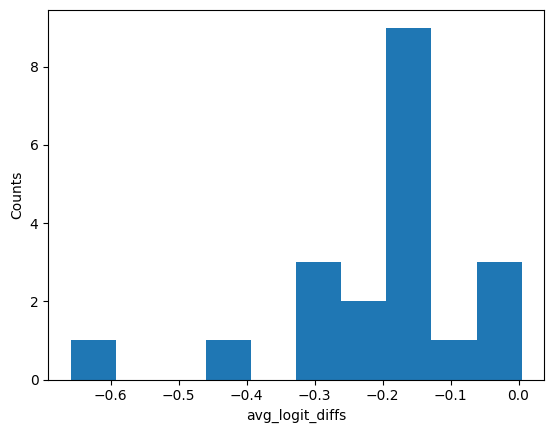

In [ ]:
import matplotlib.pyplot as plt
avg_logit_diffs_rand_ablate = torch.as_tensor(avg_logit_diffs_rand_ablate)
plt.hist(avg_logit_diffs_rand_ablate.cpu())
plt.ylabel('Counts')
plt.xlabel('avg_logit_diffs')

In [ ]:
# mean = np.mean(avg_logit_diffs_rand_ablate)
# variance = np.var(avg_logit_diffs_rand_ablate)
mean = torch.mean(avg_logit_diffs_rand_ablate)
std_dev = torch.std(avg_logit_diffs_rand_ablate)
print("Mean:", mean)
print("Standard Deviation:", std_dev.item())

Mean: tensor(-0.2024)
Standard Deviation: 0.1460614651441574


Clearly, as our circuits have much higher scores than this distribution would say is likely, it is unlikely that these circuits are consistently obtaining these scores by random chance. Note that there are 2^(total number of heads) possible choices of node sets, and this does not even count the connections (given by SEQ_POS_TO_KEEP).

1/20 -> 5%

# Plot minimality scores

In [ ]:
# %%capture
# !pip install circuitsvis

Write a function that converts into this:

In [ ]:
# K_FOR_EACH_COMPONENT = {
#     (9, 9): set(),
#     (10, 0): {(9, 9)},
#     (9, 6): {(9, 9), (10, 0)},
#     (10, 7): {(11, 10)},
#     (11, 10): {(10, 7)},
#     (8, 10): {(7, 9), (8, 6), (7, 3)},
#     (7, 9): {(8, 10), (8, 6), (7, 3)},
#     (8, 6): {(7, 9), (8, 10), (7, 3)},
#     (7, 3): {(7, 9), (8, 10), (8, 6)},
#     (5, 5): {(5, 9), (6, 9), (5, 8)},
#     (5, 9): {(11, 10), (10, 7)},
#     (6, 9): {(5, 9), (5, 5), (5, 8)},
#     (5, 8): {(11, 10), (10, 7)},
#     (0, 1): {(0, 10), (3, 0)},
#     (0, 10): {(0, 1), (3, 0)},
#     (3, 0): {(0, 1), (0, 10)},
#     (4, 11): {(2, 2)},
#     (2, 2): {(4, 11)},
#     (11, 2): {(9, 9), (10, 0), (9, 6)},
#     (10, 6): {(9, 9), (10, 0), (9, 6), (11, 2)},
#     (10, 10): {(9, 9), (10, 0), (9, 6), (11, 2), (10, 6)},
#     (10, 2): {(9, 9), (10, 0), (9, 6), (11, 2), (10, 6), (10, 10)},
#     (9, 7): {(9, 9), (10, 0), (9, 6), (11, 2), (10, 6), (10, 10), (10, 2)},
#     (10, 1): {(9, 9), (10, 0), (9, 6), (11, 2), (10, 6), (10, 10), (10, 2), (9, 7)},
#     (11, 9): {(9, 9), (10, 0), (9, 6), (9, 0)},
#     (9, 0): {(9, 9), (10, 0), (9, 6), (11, 9)},
# }

In [ ]:
# from solutions import *

# def get_score(
# 	model: HookedTransformer,
# 	ioi_dataset: IOIDataset,
# 	abc_dataset: IOIDataset,
# 	K: Set[Tuple[int, int]],
# 	C: Dict[str, List[Tuple[int, int]]],
# ) -> float:
# 	'''
# 	Returns the value F(C \ K), where F is the logit diff, C is the
# 	core circuit, and K is the set of circuit components to remove.
# 	'''
# 	C_excl_K = {k: [head for head in v if head not in K] for k, v in C.items()}
# 	model = ioi_circuit_extraction.add_mean_ablation_hook(model, abc_dataset, C_excl_K, SEQ_POS_TO_KEEP)
# 	logits = model(ioi_dataset.toks)
# 	score = logits_to_ave_logit_diff_2(logits, ioi_dataset).item()

# 	return score

# def get_minimality_score(
# 		model: HookedTransformer,
# 		ioi_dataset: IOIDataset,
# 		abc_dataset: IOIDataset,
# 		v: Tuple[int, int],
# 		K: Set[Tuple[int, int]],
# 		C: Dict[str, List[Tuple[int, int]]] = CIRCUIT,
# 	) -> float:
# 		'''
# 		Returns the value | F(C \ K_union_v) - F(C | K) |, where F is
# 		the logit diff, C is the core circuit, K is the set of circuit
# 		components to remove, and v is a head (not in K).
# 		'''
# 		assert v not in K
# 		K_union_v = K | {v}
# 		C_excl_K_score = get_score(model, ioi_dataset, abc_dataset, K, C)
# 		C_excl_Kv_score = get_score(model, ioi_dataset, abc_dataset, K_union_v, C)

# 		return abs(C_excl_K_score - C_excl_Kv_score)

# def get_all_minimality_scores(
# 		model: HookedTransformer,
# 		ioi_dataset: IOIDataset = ioi_dataset,
# 		abc_dataset: IOIDataset = abc_dataset,
# 		k_for_each_component: Dict = K_FOR_EACH_COMPONENT
# 	) -> Dict[Tuple[int, int], float]:
# 		'''
# 		Returns dict of minimality scores for every head in the model (as
# 		a fraction of F(M), the logit diff of the full model).

# 		Warning - this resets all hooks at the end (including permanent).
# 		'''
# 		# Get full circuit score F(M), to divide minimality scores by
# 		model.reset_hooks(including_permanent=True)
# 		logits = model(ioi_dataset.toks)
# 		full_circuit_score = logits_to_ave_logit_diff_2(logits, ioi_dataset).item()

# 		# Get all minimality scores, using the `get_minimality_score` function
# 		minimality_scores = {}
# 		for v, K in tqdm(k_for_each_component.items()):
# 			score = get_minimality_score(model, ioi_dataset, abc_dataset, v, K)
# 			minimality_scores[v] = score / full_circuit_score

# 		model.reset_hooks(including_permanent=True)

# 		return minimality_scores

In [ ]:
# minimality_scores = get_all_minimality_scores(model)

In [ ]:
# def plot_minimal_set_results(minimality_scores: Dict[Tuple[int, int], float]):
#     '''
#     Plots the minimality results, in a way resembling figure 7 in the paper.

#     minimality_scores:
#         Dict with elements like (9, 9): minimality score for head 9.9 (as described
#         in section 4.2 of the paper)
#     '''

#     CIRCUIT_reversed = {head: k for k, v in CIRCUIT.items() for head in v}
#     colors = [CIRCUIT_reversed[head].capitalize() + " head" for head in minimality_scores.keys()]
#     color_sequence = [px.colors.qualitative.Dark2[i] for i in [0, 1, 2, 5, 3, 6]] + ["#BAEA84"]

#     bar(
#         list(minimality_scores.values()),
#         x=list(map(str, minimality_scores.keys())),
#         labels={"x": "Attention head", "y": "Change in logit diff", "color": "Head type"},
#         color=colors,
#         template="ggplot2",
#         color_discrete_sequence=color_sequence,
#         bargap=0.02,
#         yaxis_tickformat=".0%",
#         legend_title_text="",
#         title="Plot of minimality scores (as percentages of full model logit diff)",
#         width=800,
#         hovermode="x unified"
#     )

# plot_minimal_set_results(minimality_scores)